In [1]:
from typing import List, Dict, Tuple
Node = Tuple[int, int]
import numpy as np


In [2]:
def manhattan_distance(node1: Node, node2: Node) -> float:
    return abs(node1[0] - node2[0]) + abs(node1[1] - node2[1])


class LatticeDistance:

    def __init__(self, n: int) -> None:
        self.n = n

    def __call__(self, node1: Node, node2: Node) -> float:
        dx = abs(node1[0] - node2[0])
        dy = abs(node1[1] - node2[1])
        if dx > self.n / 2:
            dx = self.n - dx
        if dy > self.n / 2:
            dy = self.n - dy
        return dx + dy

def euclidean_distance(node1: Node, node2: Node) -> float:
    return ((node1[0] - node2[0])**2 + (node1[1] - node2[1])**2)**0.5

In [3]:
def num_of_distance(n,i):
    assert n % 2 == 1
    diameter = (n-1) // 2
    if i == 0:
        return 1
    if i <= diameter:
        return 4 * i
    z = 2*diameter - i+1
    return 4 * z

def generate_offset(n, i, o):
    assert n % 2 == 1
    assert i > 0

    diameter = (n-1) // 2
    num_possible = num_of_distance(n, i)
    assert 0 <= o < num_possible, f"o={o}, num_possible={num_possible}"

    start = max(0, i - diameter)
    end = min(diameter, i)

    is_cropped = i > diameter

    if is_cropped:
        y_sign = 1 if o % 2 == 0 else -1
        if o < num_possible // 2:
            x = -end + o // 2
            y = i - abs(x)
            return (x, y * y_sign)
        else:
            x = start + (o - num_possible // 2) // 2
            y = -i + abs(x)
            return (x, y * -y_sign)
    else:
        if o == 0:
            return -end, 0
        if o == num_possible - 1:
            return end, 0
        if o < num_possible // 2:
            o -= 1
            x = -end + 1 + o // 2
            y = i - abs(x)
            y_sign = 1 if o % 2 == 0 else -1
            return (x, y * y_sign)
        else:
            o -= num_possible // 2
            if o == 0:
                return start, -end
            o -= 1
            x = start + 1 + o // 2
            y = i - abs(x)
            y_sign = 1 if o % 2 == 0 else -1
            return (x, y * y_sign)

In [65]:
class MultinomialDistanceSampler:

    def __init__(self, n: int, alpha: float, distorted_probas: bool) -> None:
        assert n % 2 == 1
        self.n = n
        max_distance = n-1
        distance_probas = np.array([0] + [i**-alpha for i in range(1, max_distance+1)])
        distance_probas[1] = 0
        if distorted_probas:
            for d in range(max_distance+1):
                distance_probas[d] *= num_of_distance(n, d)
        distance_probas /= distance_probas.sum()
        self.values = np.arange(max_distance+1)
        self.probas = distance_probas

    def sample(self, n_samples: int) -> int:
        return np.random.choice(self.values, p=self.probas, size=n_samples)
    

class OffsetSampler:

    def __init__(self, n: int, alpha: float, distorted_probas: bool) -> None:
        self.n = n
        self.distance_sampler = MultinomialDistanceSampler(n, alpha, distorted_probas)

    def sample(self) -> Node:
        distance = self.distance_sampler.sample(1)[0]
        offset = np.random.randint(num_of_distance(self.n, distance))
        return generate_offset(self.n, distance, offset)
        

class PeriodicalLatticeSimulator:

    def __init__(self, n: int, alpha: float, distorted_probas: bool) -> None:
        assert n % 2 == 1, "Works for odd n only."
        self.n = n
        self.alpha = alpha
        self.lattice_distance = LatticeDistance(n)
        self.diameter = (n-1)//2
        self.offset_sampler = OffsetSampler(n, alpha, distorted_probas)


    def simulate(self, target: Node) -> int:
        assert target[0] <= self.diameter and target[1] <= self.diameter, "Target is out of bounds."
        n_rounds = 0
        while target != (0, 0):
            n_rounds += 1
            long_range = list(map(abs, self.offset_sampler.sample()))
            long_range_distance = self.lattice_distance(target, long_range)
            current_distance = sum(target)
            if long_range_distance < current_distance:
                target = (target[0] - long_range[0], target[1] - long_range[1])
            else:
                if target[0] > 0:
                    target = (target[0] - 1, target[1])
                else:
                    target = (target[0], target[1] - 1)
            # corrigate flips
            target = (abs(target[0]), abs(target[1]))
        return n_rounds
        

In [71]:
from tqdm import tqdm

NSIM = 150
N = 20_001

result = []
for alpha in tqdm(np.linspace(0, 2.5, 26), total=26):
    curr_result = []
    for _ in range(NSIM):
        simulator = PeriodicalLatticeSimulator(N, alpha, distorted_probas=False)
        target = (np.random.randint(N//2), np.random.randint(N//2))
        steps = simulator.simulate(target)
        curr_result.append(steps)
    result.append((np.mean(curr_result), np.std(curr_result)))


 88%|████████▊ | 23/26 [03:06<01:16, 25.40s/it]

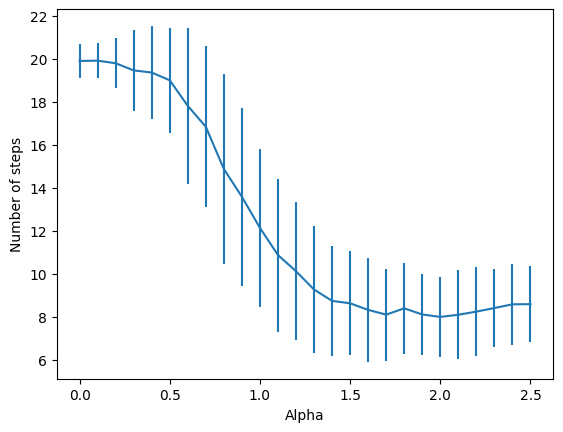

In [ ]:
import matplotlib.pyplot as plt

result = np.array(result)
plt.errorbar(np.linspace(0, 2.5, 26), result[:, 0], yerr=result[:, 1])
plt.xlabel("Alpha")
plt.ylabel("Number of steps")
plt.show()

In [58]:
import matplotlib.pyplot as plt
mds = MultinomialDistanceSampler(15, 1)
plt.hist(mds.sample(100000), bins=15-2)
plt.plot(mds.values, mds.probas * 100000)

TypeError: __init__() missing 1 required positional argument: 'distorted_probas'